# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify the generating transmissivity fiels.\
We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

### Importing necessary libraries

In [1]:
# Standard library imports
import sys

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit

import scipy.stats as stats
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Input, Dense, Add

#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform


# Local module imports
sys.path.append('../../')
sys.path.append('../../solver')
#sys.path.append('./src/InverseProblems')
#sys.path.append('./src/utils')
from utils import * 
from plotting import *
from random_process import *


2024-09-22 10:54:36.406526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ray module not found. Multiprocessing features are not available


### Decide sample to use for experimental data

In [2]:
sample = 135 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_coarse_"+str(sample)

### Load Data and define testing sample

In [3]:
# Extract test data for visualization or further processing
n_eig = 64
X_values = np.loadtxt('../../data/50-25-10/X_test_50resolution.csv', delimiter = ',')
y_values = np.loadtxt('../../data/50-25-10/y_test_50resolution.csv',delimiter = ',')

# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]

### Load Surrogate Models

#### Load Low Fidelity 

In [4]:
# Choose the model parameters 
n_samples_lf = 16000
coeff_lf = 1e-08

In [5]:
# Initialize the neural network model
model_l = Sequential([
    Dense(256, input_shape=(X_values.shape[1],), activation='gelu'),
    Dense(256, activation='gelu'),
    Dense(256, activation='gelu'),
    Dense(256, activation='gelu'),
    Dense(256, activation='gelu'),
    Dense(256, activation='gelu'),
    Dense(25, activation='linear')
])

model_l = load_model(f'../models/model_50resolution_{n_samples_lf}samples_1_coeff{coeff_lf}.keras')

/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Load High Fidelity 

In [6]:
# Choose the model parameters 
n_samples_lf_mf = 64000
coeff_lf_mf = 1e-09

In [8]:
# Initialize the neural network model
model_l_mf = Sequential([
    Dense(256, input_shape=(X_values.shape[1],), activation='gelu'),
    Dense(256, activation='gelu'),
    Dense(256, activation='gelu'),
    Dense(256, activation='gelu'),
    Dense(256, activation='gelu'),
    Dense(256, activation='gelu'),
    Dense(25, activation='linear')
])

model_l_mf = load_model(f'../models/model_25resolution_{n_samples_lf_mf}samples_1_coeff{coeff_lf_mf}.keras')

/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Choose the model parameters 
n_samples = 16000
coeff = 1e-08

In [10]:
n_neurons = 256
# Initialize the neural network model
# Define the three branches of the model
input_params = Input(shape=(X_values.shape[1],))
input_pod = Input(shape=(y_values.shape[1],))

# Define the first branch (parameters)
x1 = Dense(n_neurons, activation='gelu')(input_params)
x1 = Dense(n_neurons, activation='gelu')(x1)
x1 = Dense(n_neurons, activation='gelu')(x1)
x1 = Dense(n_neurons, activation='gelu')(x1)
x1 = Dense(n_neurons, activation='gelu')(x1)
x1 = Dense(n_neurons, activation='gelu')(x1)

# Define the second branch (POD)
x2 = Dense(n_neurons, activation='gelu')(input_pod)

# # Define the second branch (POD)
# x3 = Dense(n_neurons, activation='gelu', kernel_regularizer=l2(w))(input_nn)

# Combine the outputs of the three branches
combined = Add()([x1,x2])
combined = Dense(n_neurons, activation='gelu')(combined)
output = Dense(25, activation='linear')(combined)

# Create the model
model_h = Model(inputs=[input_params,input_pod], outputs=output)


model_h = load_model(f'..//models/model_2step_50-25resolution_{n_samples}samples_1_coeff{coeff}.keras')

#### Combine High and Low 

In [11]:
model_lf = lambda input : model_l(input.reshape(1,64)).numpy().reshape(25)
model_hf = lambda input: model_h([input.reshape(1,64), model_l_mf(input.reshape(1,64)).numpy()]).numpy().reshape(25)

## Analysis with more complete diagnostics to investigate a particular scenario
Choose the wanted set of parameters to run this part and have more accurate diagnostics

#### Define Prior, likelyhood and proposal

In [30]:
noise = 0.001

# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(n_eig), cov = np.eye(n_eig))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise**2 * np.eye(25) *100
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)  
y_distribution_fine = tda.GaussianLogLike(y_observed, cov_likelihood) 

#### Perform least square optimization for each starting point

In [106]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

bounds = (-3*np.ones(n_eig), 3*np.ones(n_eig))

# Iterate over each parameter start point to perform optimizatio
# Perform least squares optimization given the observed data, forward model,
# start point, and parameter bounds
optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.zeros(n_eig), 
        bounds=bounds,
        l2_coeff = 0#1e-6
    )

# Append the optimized parameters to the list of initial guesses
initial_guesses.append(optimized_params)

# Print the optimized parameters for this iteration
print(f"Optimized Params : {optimized_params}")


Real Params:  [ 0.8407655   2.28055688 -0.73132842  0.11531569 -0.02046974  0.75240588
 -0.45326316  1.98660629  0.79825229 -0.48088112 -0.50092908  0.20994566
  2.29107917  1.95036147 -0.92260965 -0.38006913 -1.33858626  2.62628026
 -1.11695521  0.77824203  0.12232429  0.16879104 -0.46200188  0.21059535
  1.38707264 -0.39080101  1.62471692  0.47209964 -1.43103133 -0.04769343
  0.59538075 -0.83332336 -0.44803607 -1.369462    0.99916334  1.30938291
  0.63006791 -0.40464538 -1.84444994 -0.78459737 -0.45910707  1.15270142
 -0.67361603 -0.18464473 -0.2611004   1.00975366 -1.30978859  0.71181477
 -0.14723574 -0.73991872  0.71183638  0.98769694  0.66920148  1.37955852
 -0.88711374  1.03838088 -0.34814983  0.92254989 -0.46067547  1.55114913
 -0.52789459  0.92058552  0.18960496  0.22095517]
Optimized Params : [ 0.62319596  1.45711131 -1.25726587  0.55853426 -0.28107031  0.64276798
 -0.46835577  1.17894393  0.10621698  0.16571764 -0.49718517  0.31738294
  1.51587274  1.60885986 -0.67962261  0.0

#### Do Metropolis Hastings Sampling

Set the parameters for the algorithm 

In [111]:
scaling = 0.05
n_iter = 55000
burnin = 5000
thin = 50

In [112]:
#cov = np.diag(np.linspace(1,5,n_eig))
cov = np.eye(n_eig)

In [113]:
# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine  = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [ my_posterior_coarse, my_posterior_fine ]
# random walk Metropolis
#my_proposal = tda.GaussianRandomWalk(C=covariance_matrix*1e-19, scaling= scaling)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)
#my_proposal = tda.AdaptiveMetropolis(C0=np.eye(n_eig), sd = 0.2)


In [114]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []

# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    ess = az.ess(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", ess,"\n\n\n")
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results
#print("\nRhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')))

#print('Mean ESS:' , np.mean(ESS_values, axis = 0))
#print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0)) )


Sampling chain 1/1


Running chain, α = 0.27: 100%|██████████| 55000/55000 [05:36<00:00, 163.58it/s]


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 7.793
    x1       float64 8B 21.17
    x2       float64 8B 25.77
    x3       float64 8B 50.39
    x4       float64 8B 7.989
    x5       float64 8B 18.54
    ...       ...
    x58      float64 8B 2.112
    x59      float64 8B 12.23
    x60      float64 8B 26.57
    x61      float64 8B 9.715
    x62      float64 8B 1.793
    x63      float64 8B 14.31 





/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Let's look at the trace plot of one chain

#### Diagnostics 

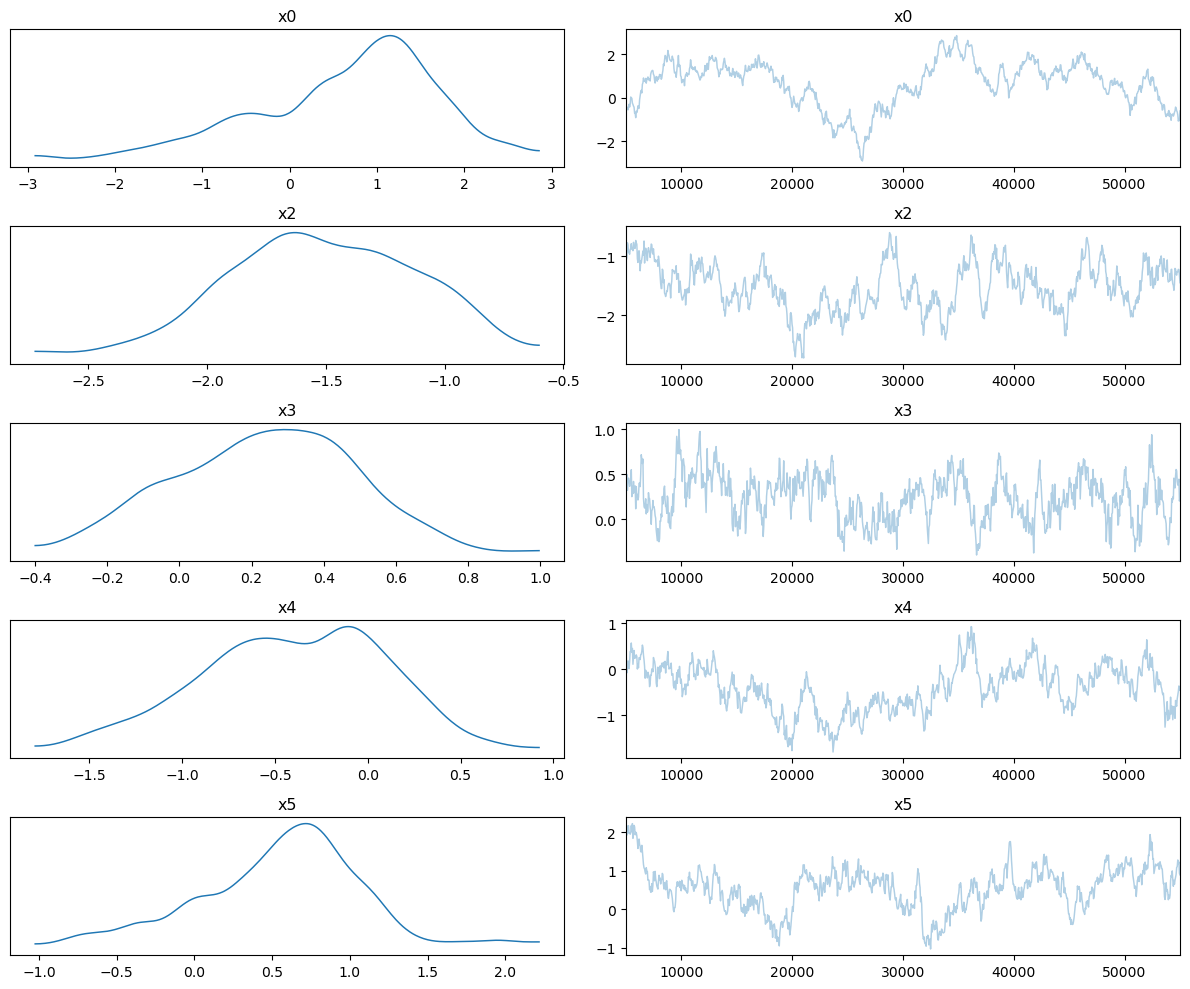

In [115]:
# Plot trace of the first set of samples
az.plot_trace(idata, var_names=['x0', 'x2', 'x3','x4','x5'])
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

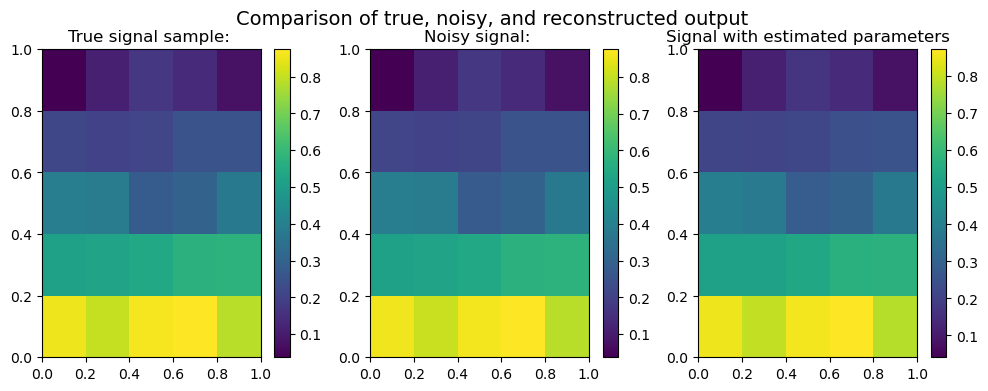

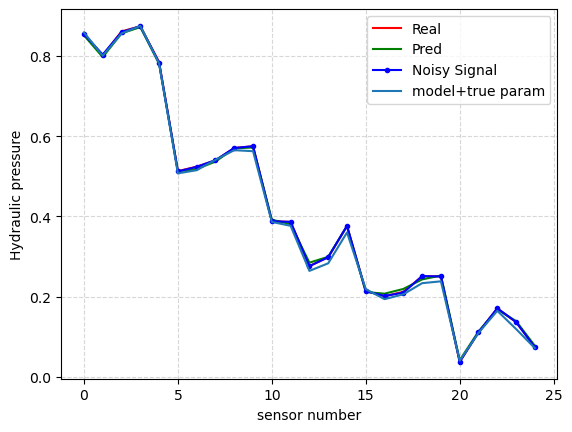

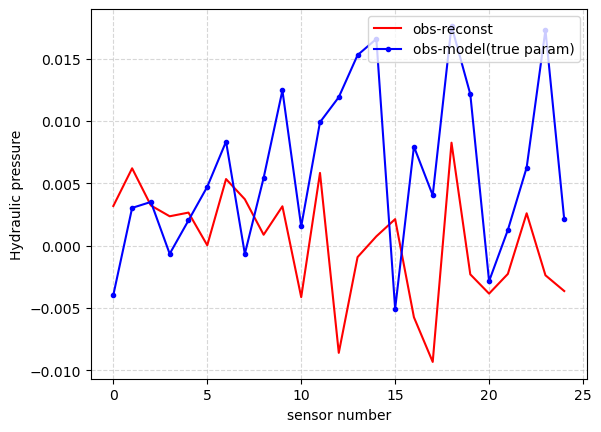

In [116]:
# Plotting and data collection
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_results( y_true, y_observed, model_hf, data, n_eig,x_true)

Finally, let's look at the parameters distribution

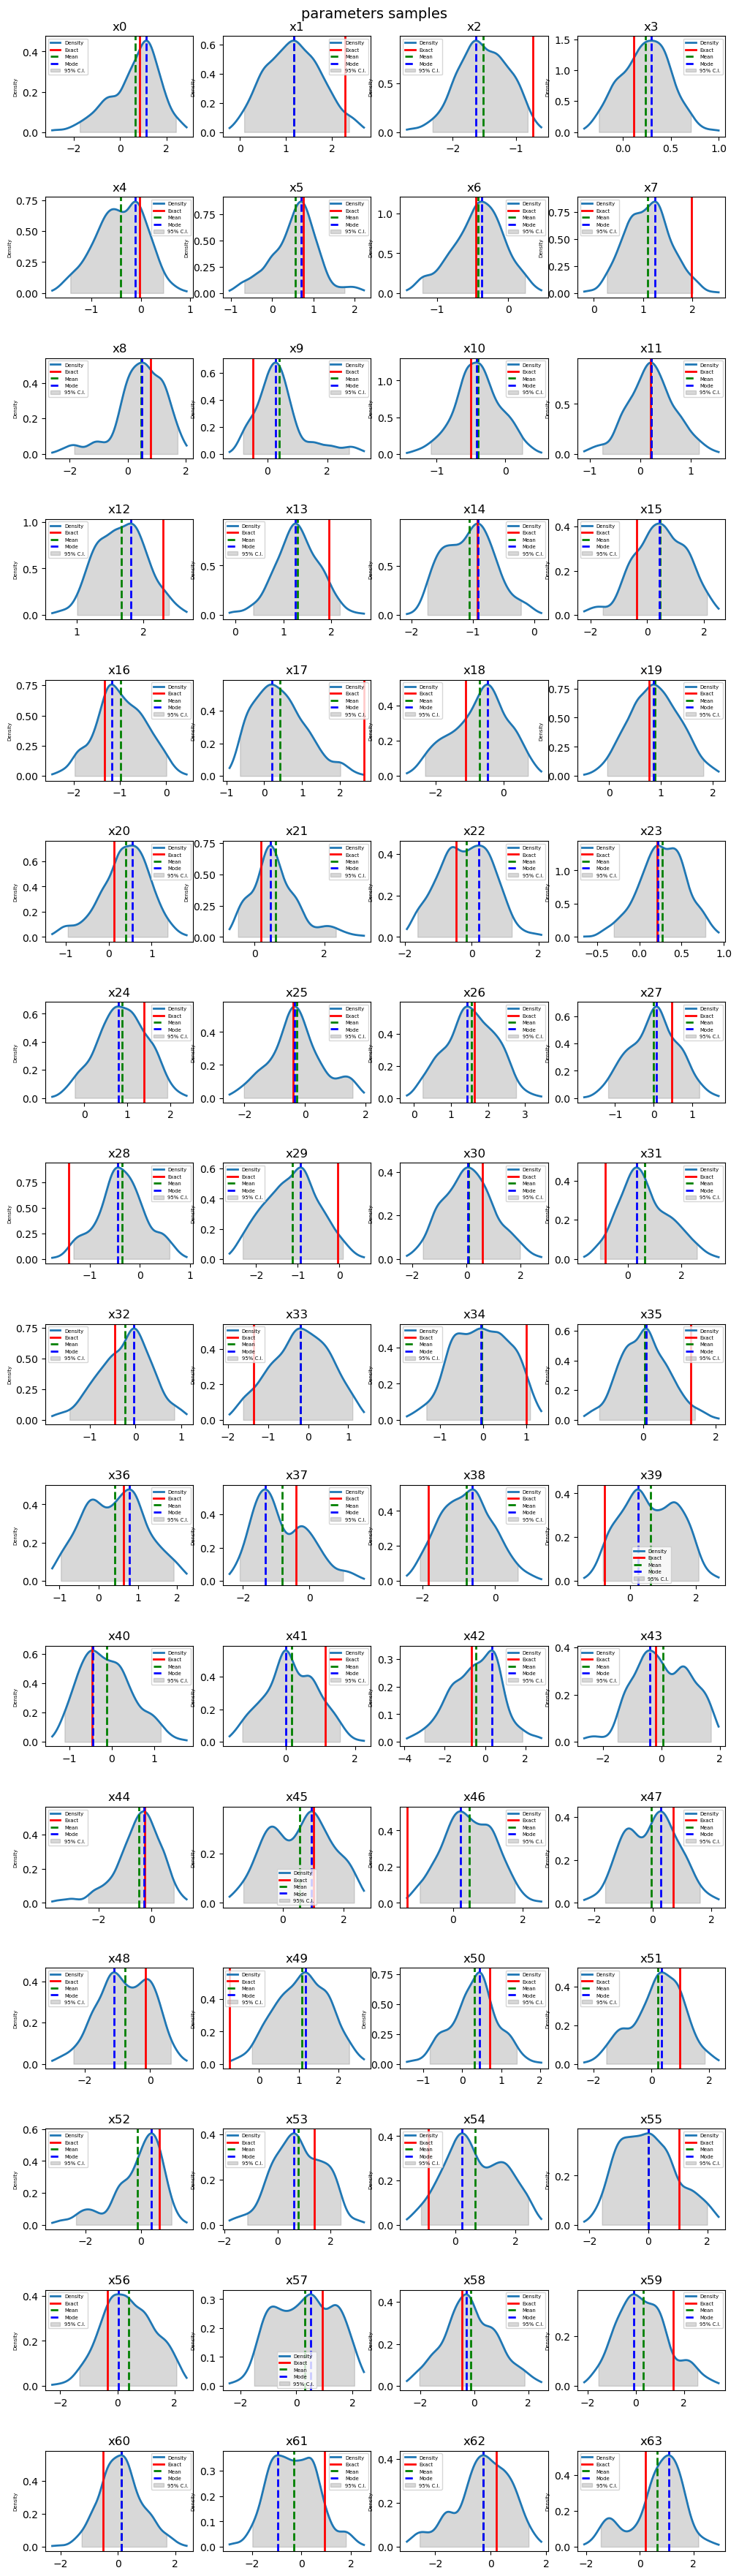

In [117]:
keys = ['x'+ str(i) for i in range(64)]
plot_parameter_distributions(data, x_true, keys, n_eig) 

#### Reconstructed field 

<Figure size 1000x400 with 0 Axes>

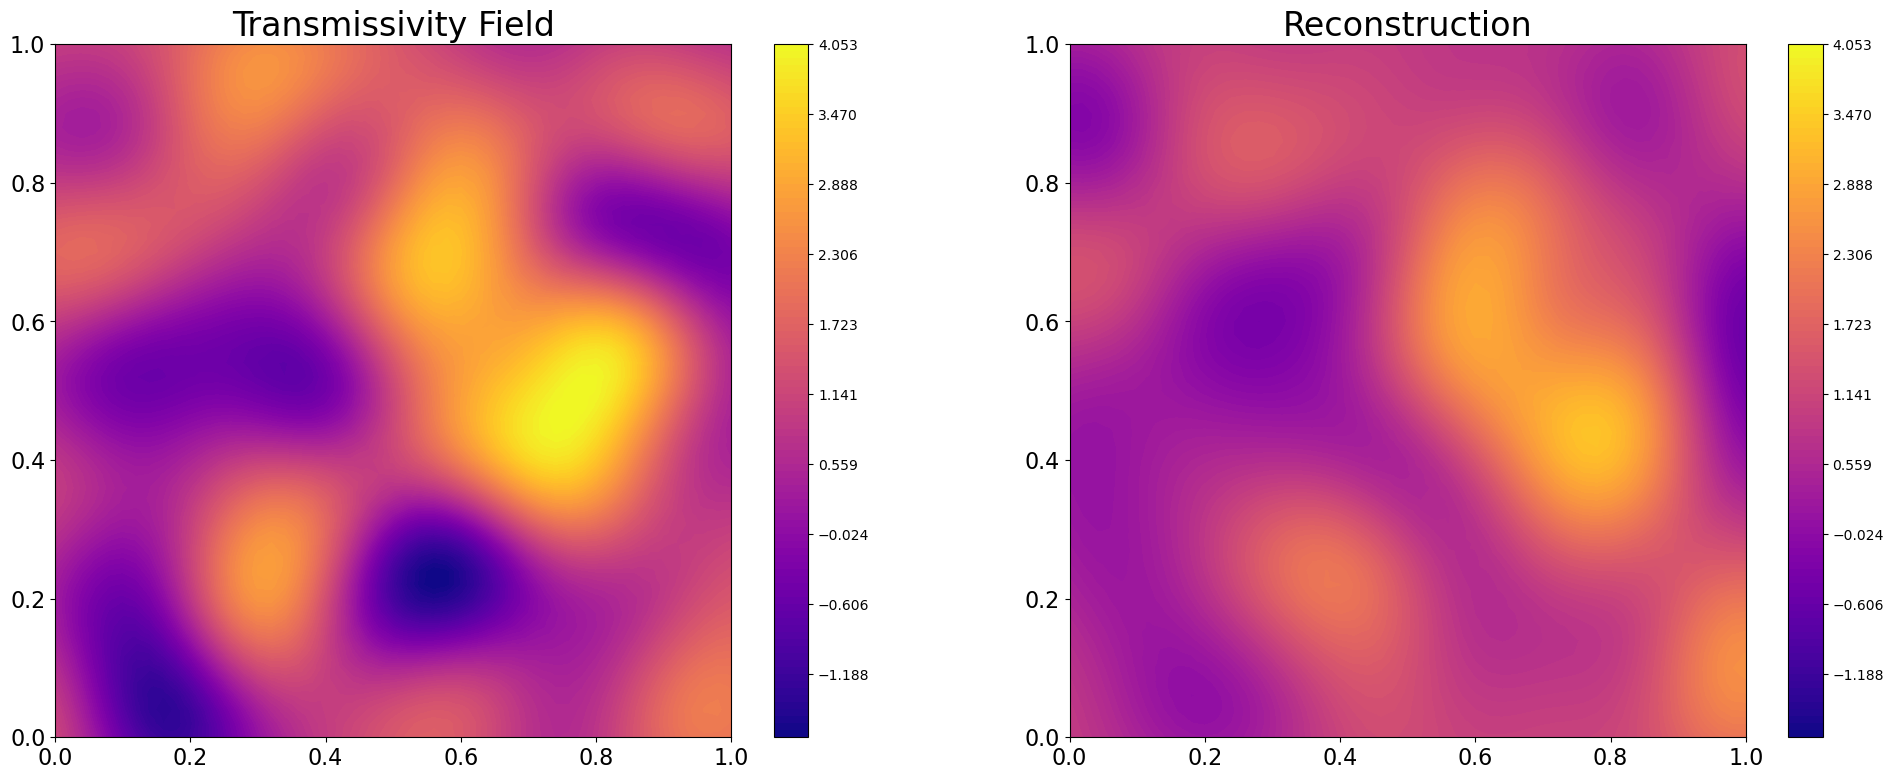

In [118]:
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False)

## Different scenarios

### Likelyhood with multiplicative coefficient 

In [12]:
noise = 0.001
scaling = 0.015 #0.04
n_iter =  30000 #55000
burnin = 5000 #5000
thin = 20
sub_sampling = 1


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(n_eig), cov = np.eye(n_eig))

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood*10)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood*10)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α_c = 0.310, α_f = 0.21: 100%|██████████| 30000/30000 [04:58<00:00, 100.52it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 2.637
    x1       float64 8B 3.237
    x2       float64 8B 1.581
    x3       float64 8B 2.024
    x4       float64 8B 1.411
    x5       float64 8B 1.313
    ...       ...
    x58      float64 8B 8.384
    x59      float64 8B 2.186
    x60      float64 8B 7.197
    x61      float64 8B 1.427
    x62      float64 8B 1.464
    x63      float64 8B 7.78 





<Figure size 1000x400 with 0 Axes>

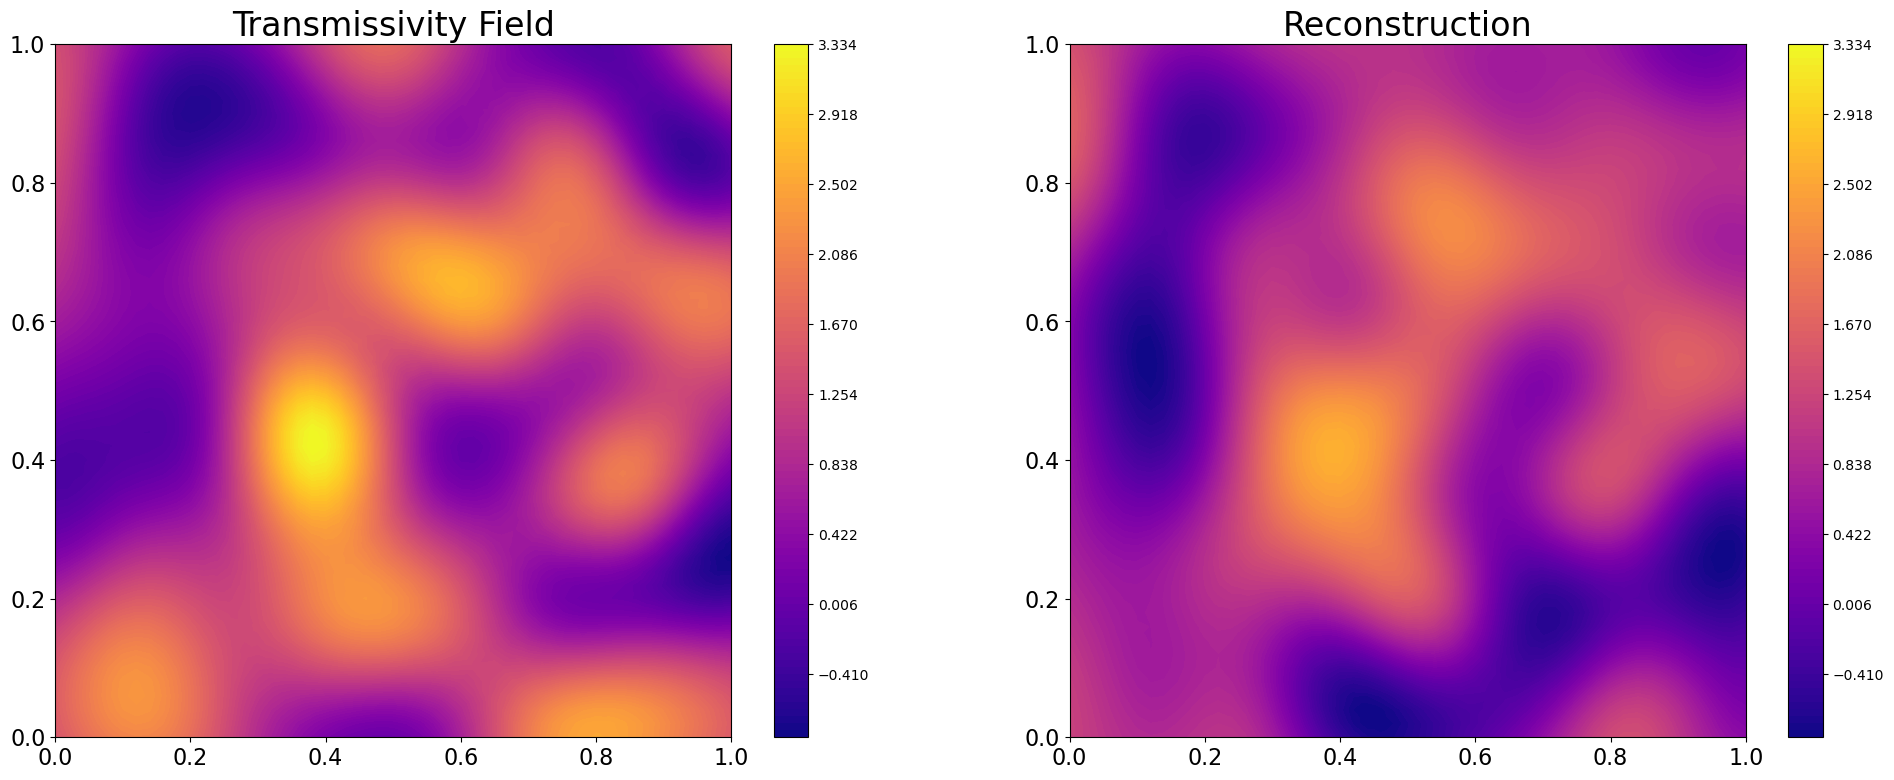

In [13]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### Higher Noise 

In [14]:
noise = 0.01
scaling = 0.04
n_iter =  30000 #55000
burnin = 5000 #5000
thin = 20
sub_sampling = 1


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(n_eig), cov = np.eye(n_eig))

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")


Sampling chain 1/1


Running chain, α_c = 0.330, α_f = 0.25: 100%|██████████| 30000/30000 [05:21<00:00, 93.43it/s] 
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 13.83
    x1       float64 8B 7.953
    x2       float64 8B 6.143
    x3       float64 8B 10.85
    x4       float64 8B 12.42
    x5       float64 8B 7.339
    ...       ...
    x58      float64 8B 3.166
    x59      float64 8B 16.5
    x60      float64 8B 8.23
    x61      float64 8B 1.859
    x62      float64 8B 4.52
    x63      float64 8B 9.084 





In [15]:
e = [ess.data_vars['x'+str(i)].values for i in range(64)]
np.mean(e)

8.756645618279727

<Figure size 1000x400 with 0 Axes>

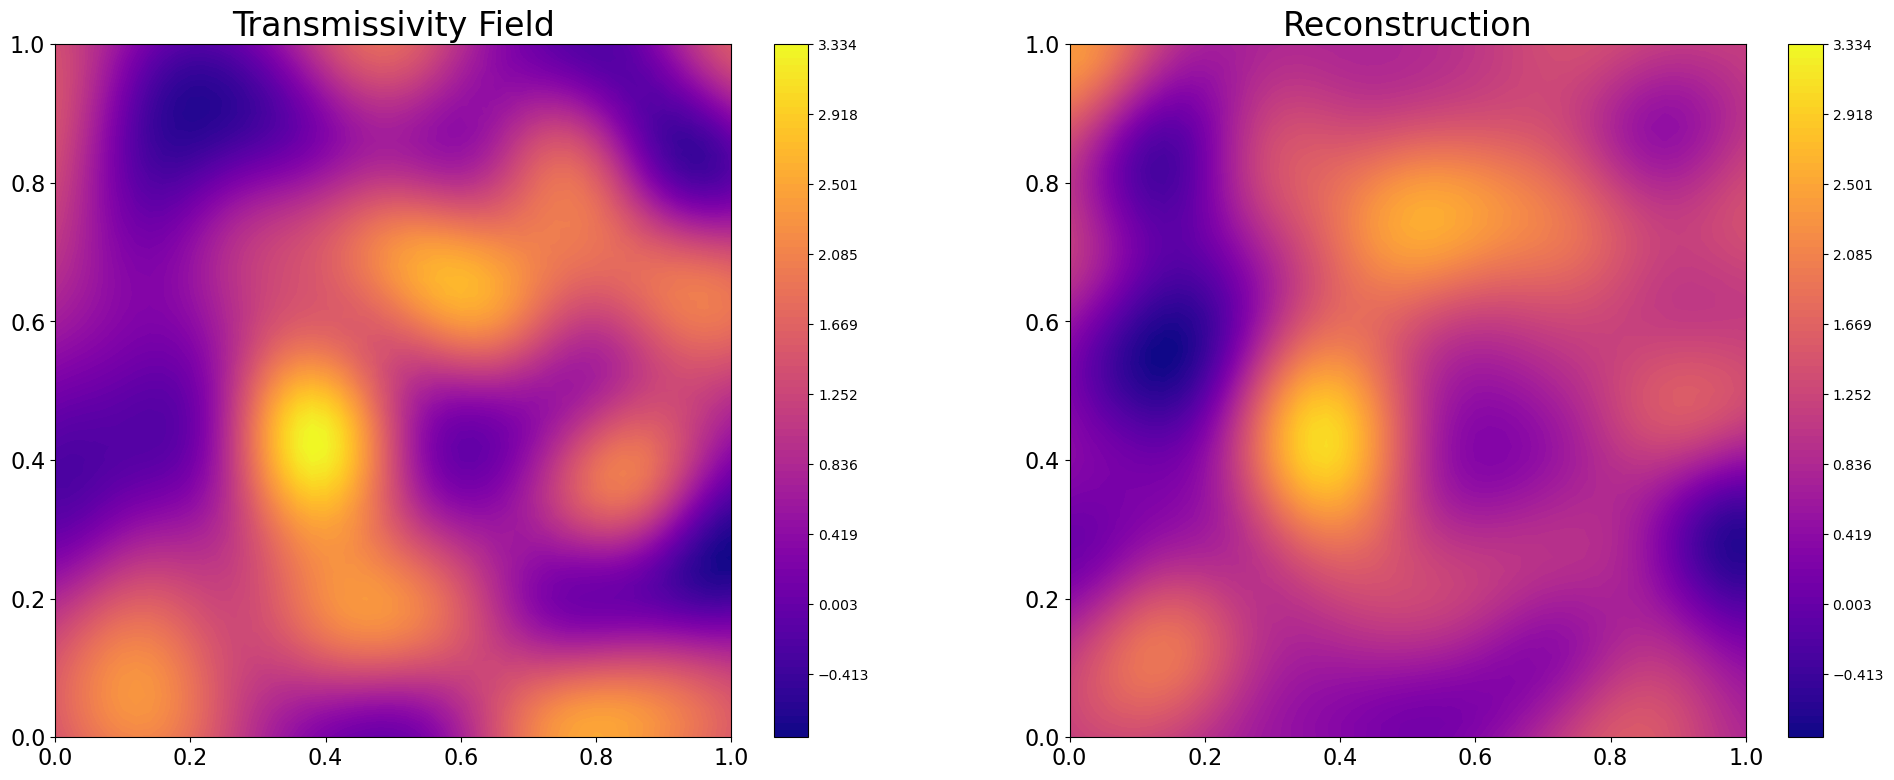

In [16]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### No noise 

In [47]:
noise = 0.00
scaling = 0.04
n_iter =  30000 #55000
burnin = 5000 #5000
thin = 20
sub_sampling = 1


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(n_eig), cov = np.eye(n_eig))

# LIKELYHOOD
cov_likelihood = 0.01**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 55000/55000 [05:35<00:00, 163.74it/s]


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 15.62
    x1       float64 8B 5.568
    x2       float64 8B 9.743
    x3       float64 8B 3.501
    x4       float64 8B 1.971
    x5       float64 8B 2.247
    ...       ...
    x58      float64 8B 10.77
    x59      float64 8B 24.75
    x60      float64 8B 8.458
    x61      float64 8B 1.992
    x62      float64 8B 1.819
    x63      float64 8B 7.932 





/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


<Figure size 1000x400 with 0 Axes>

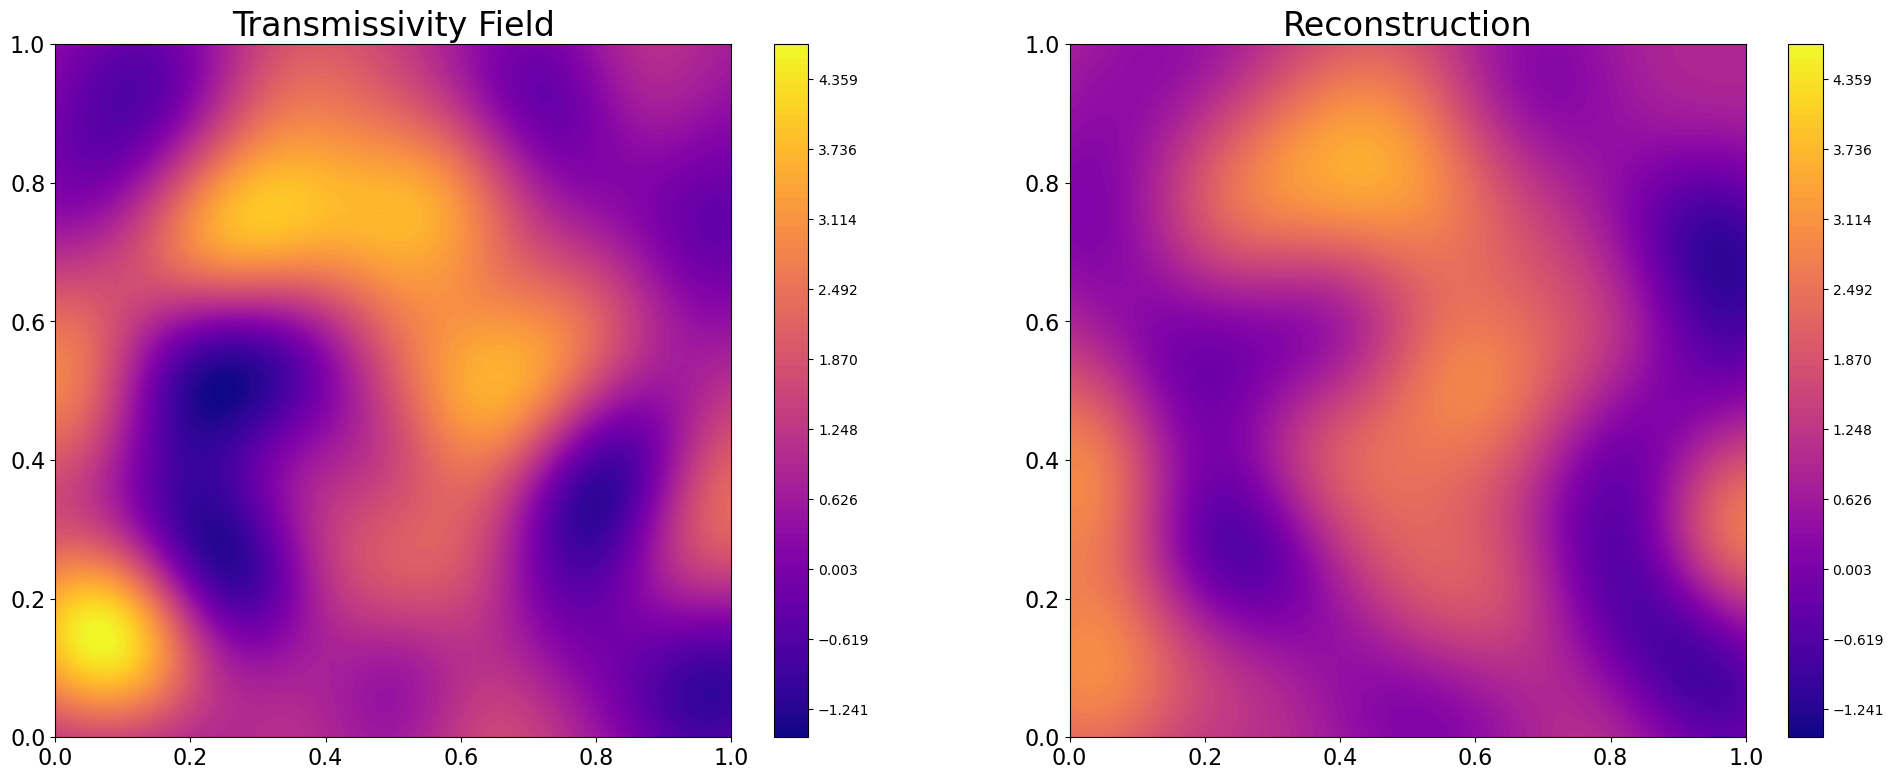

In [48]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### True likelyhood

In [17]:
noise = 0.001
scaling = 0.007
n_iter =  30000 #55000
burnin = 5000 #5000
thin = 20
sub_sampling = 1


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(n_eig), cov = np.eye(n_eig))

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α_c = 0.600, α_f = 0.67:   0%|          | 0/30000 [00:00<?, ?it/s]/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/tinyDA/proposal.py:340: RuntimeWarning: overflow encountered in exp
  return np.exp(proposal_link.likelihood - previous_link.likelihood)
Running chain, α_c = 0.350, α_f = 0.17: 100%|██████████| 30000/30000 [04:50<00:00, 103.35it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 1.834
    x1       float64 8B 7.918
    x2       float64 8B 7.826
    x3       float64 8B 3.195
    x4       float64 8B 1.655
    x5       float64 8B 6.715
    ...       ...
    x58      float64 8B 1.513
    x59      float64 8B 2.052
    x60      float64 8B 1.457
    x61      float64 8B 1.384
    x62      float64 8B 2.039
    x63      float64 8B 7.059 





<Figure size 1000x400 with 0 Axes>

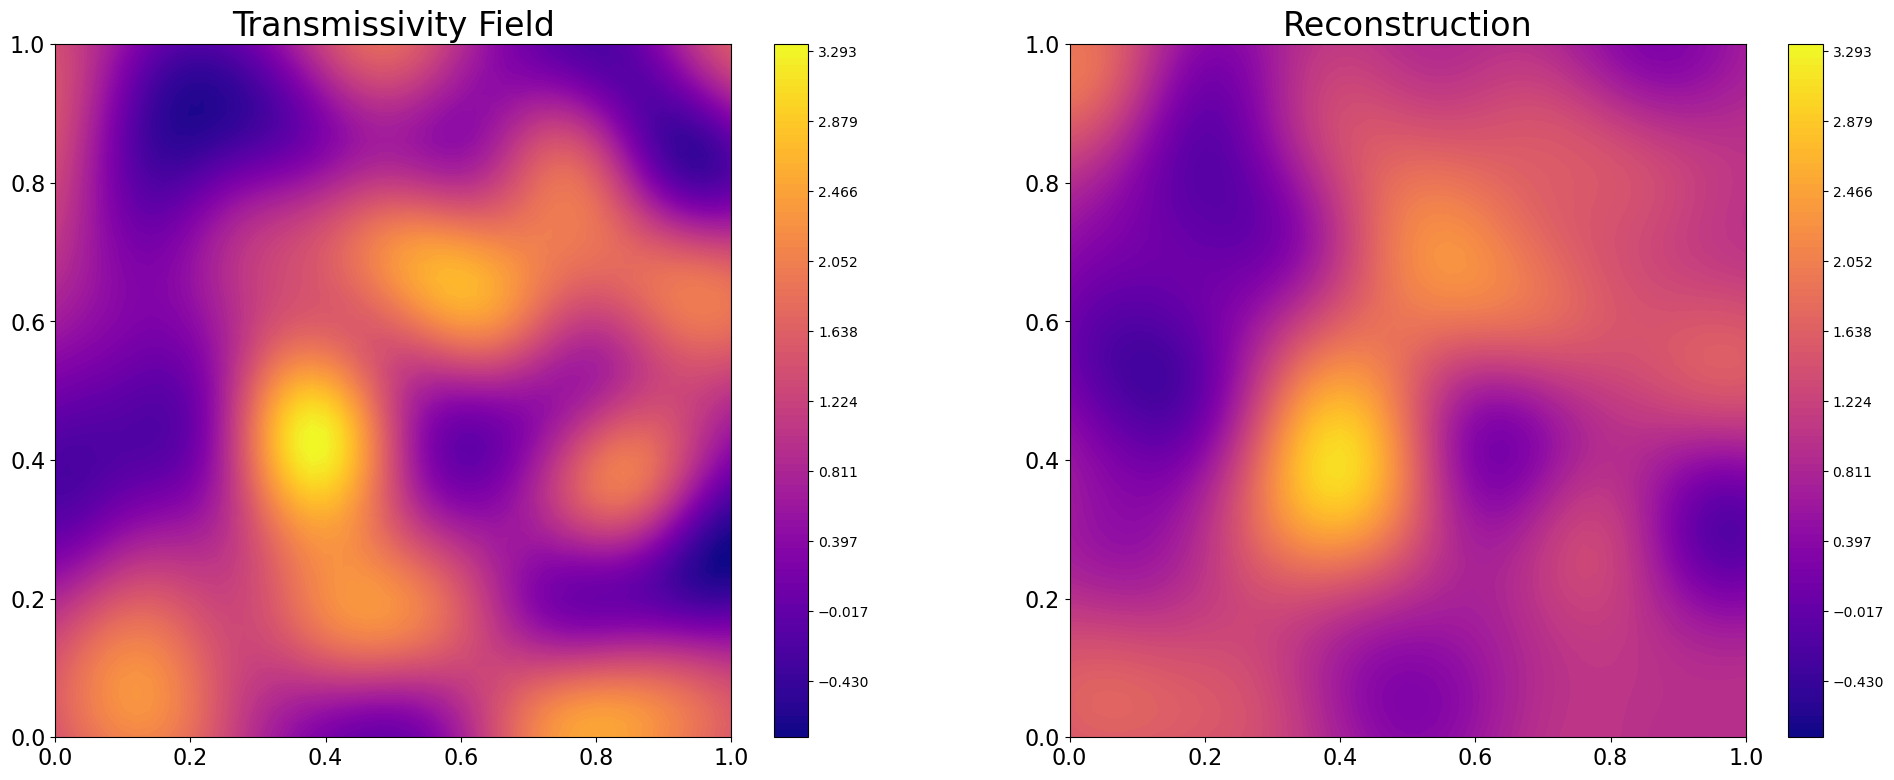

In [18]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

In [19]:
e = [ess.data_vars['x'+str(i)].values for i in range(64)]
np.mean(e)

4.773880334657701